# 1 Import libraries
The required libraries for this notebook are list below

In [1]:
# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import os
from tqdm.auto import tqdm

# Libraries for image preprocessing, data augmentation and feature extraction
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
import imgaug.augmenters as iaa
import pywt

# Libraries for scaling and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Libraries for cross-validation
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# Libraries for classifiers used
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics

# 2 Data Preprocessing

In [2]:
df_train = pd.read_csv('./dataset/label.csv')
df_train.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


In [3]:
df_train['label'].value_counts()

glioma_tumor        860
meningioma_tumor    855
pituitary_tumor     831
no_tumor            454
Name: label, dtype: int64

## 2.1 Create function for binary labelling of classes
0 for no tumor, 1 for tumor

In [4]:
def create_classes(df):
    '''
    Inputs
        df: Label data.
        
    Return
        classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    '''
    
    classes = []
    for label in df['label']:
        if 'no_tumor' in label:
            classes.append(0)
        elif 'glioma_tumor' in label:
            classes.append(1)
        elif 'meningioma_tumor' in label:
            classes.append(2)
        elif 'pituitary_tumor' in label:
            classes.append(3)
    return classes

## 2.2 Augment training images
Augment the images by rotating it, flipping it horizontally, adding gaussian blur, shearing, sharpening and blurring edges.
This was only done for images with no tumor to balance the training dataset

In [5]:
train_path = './dataset/image'
original_images = []
for filename in tqdm(df_train['file_name']):
    # obtain pixel data from the image after converting image to grayscale
    im = imread(os.path.join(train_path, filename), as_gray=True)
    original_images.append(im)

# Index of images with no_tumor label
noTumor_idx = df_train.index[df_train['label'] == 'no_tumor'].tolist()
# Index of images with glioma_tumor label
glioma_idx = df_train.index[df_train['label'] == 'glioma_tumor'].tolist()
# Index of images with meningioma_tumor label
meningioma_idx = df_train.index[df_train['label'] == 'meningioma_tumor'].tolist()

# List of images with no_tumor label
images_noTumor = []
for idx in tqdm(noTumor_idx):
    images_noTumor.append(original_images[idx])

# # Choose random indexes of images with glioma_tumor label up to 1/4 of the total number
# glioma_idx_sample = random.choices(glioma_idx, k=math.floor(len(glioma_idx)/4))
# # List of images with glioma_tumor label
# images_glioma = []
# for idx in tqdm(glioma_idx_sample):
#     images_glioma.append(original_images[idx])

# # Choose random indexes of images with meningioma_tumor label up to 1/4 of the total number
# meningioma_idx_sample = random.choices(
#     meningioma_idx, k=math.floor(len(meningioma_idx)/4))
# # List of images with meningioma_tumor label
# images_meningioma = []
# for idx in tqdm(meningioma_idx_sample):
#     images_meningioma.append(original_images[idx])

# Data Augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

# Double the no_tumor images
images_aug_noTumor = seq(images=images_noTumor)
# # Increases the glioma_tumor images by 1.25
# images_aug_glioma = seq(images=images_glioma)
# # Increases the meningioma_tumor images by 1.25
# images_aug_meningioma = seq(images=images_meningioma)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
# images_augmented = original_images + images_aug_noTumor + \
#     images_aug_glioma + images_aug_meningioma
images_augmented = original_images + images_aug_noTumor

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

## 2.3 Preprocess train images
Augmented images are de-noised by using Discrete Wavelet Transform, decreasing image size from (512,512) to (256,256)

In [47]:
augmentation = True

if augmentation:
    images = images_augmented
else:
    images = original_images

# DWT transforms image to (256,256) from (516,516), also for denoising
train_images = []
for image in tqdm(images):
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    train_images.append(LL)

  0%|          | 0/3454 [00:00<?, ?it/s]

## 2.4 Preprocess test images

In [48]:
df_test = pd.read_csv('./test/label.csv')
test_path = './test/image'

test_images = []
for filename in tqdm(df_test['file_name']):
    im = imread(os.path.join(test_path, filename), as_gray=True)
    coeffs = pywt.dwt2(im, 'haar')
    LL, (LH, HL, HH) = coeffs
    test_images.append(LL)

  0%|          | 0/200 [00:00<?, ?it/s]

# 3 Feature Extraction

## 3.1 Histogram of Orientated Gradients (HOG)
Function to extract HOG information from images

In [49]:
def extract_hog(images_pixelData):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data.

    Return
       hog_features: A list of HOG features for each image.
    '''
    hog_features = []

    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')

        hog_features.append(fd)

    return hog_features

## 3.2 Local Binary Pattern (LBP)
Function to extract LBP information from images

In [50]:
def extract_lbp(images_pixelData, numPoints, radius):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data,
        numPoints: Number of circularly symmetric neighbour set points,
        radius: Radius of circle (spatial resolution of the operator).

    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(
            images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))

        lbp_features.append(hist)
    return lbp_features

## 3.3 Multi-Level DWT
Function to transform images multiple times with DWT

In [51]:
def extract_multidwt(images_pixelData, levels):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data,
        levels: Levels of multi-DWT to use.

    Return
       multidwt: A list of Local Binary Pattern (LBP) features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        LL = images_pixelData[i]
        for j in range(levels):
            coeffs = pywt.dwt2(LL, 'haar')
            LL, (LH, HL, HH) = coeffs

        multidwt.append(LL.ravel())

    return multidwt

# 4 Training and Testing Model

## 4.1 Creating Train and Test set
The feature to use (HOG, LBP or Multi-DWT) can be selected by changing the value of feature

In [76]:
feature = 'lbpdwt'

# Doing classification with image HOG features
if feature == 'hog':
    train_taskB = pd.DataFrame(data=extract_hog(train_images))
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)

    test_taskB = pd.DataFrame(data=extract_hog(test_images))
    test_taskB['num_label'] = create_classes(df_test)

# Doing classification with image LBP features
elif feature == 'lbp':
    train_taskB = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)

    test_taskB = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_taskB['num_label'] = create_classes(df_test)

# Doing classification with Multi-DWT image data
elif feature == 'multidwt':
    train_taskB = pd.DataFrame(data=extract_multidwt(train_images, 2))
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)

    test_taskB = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskB['num_label'] = create_classes(df_test)

# Doing classification with image HOG and LBP features
elif feature == 'hoglbp':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_taskB = pd.concat(
        [train_hog, train_lbp], axis=1)
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)
        
    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_taskB = pd.concat(
        [test_hog, test_lbp], axis=1)
    test_taskB['num_label'] = create_classes(df_test)
    
# Doing classification with image HOG and DWT features
elif feature == 'hogdwt':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_multidwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskB = pd.concat(
        [train_hog, train_multidwt], axis=1)
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)
        
    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_multidwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskB = pd.concat(
        [test_hog, test_multidwt], axis=1)
    test_taskB['num_label'] = create_classes(df_test)
    
# Doing classification with image LBP and DWT features
elif feature == 'lbpdwt':
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_multidwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskB = pd.concat(
        [train_lbp, train_multidwt], axis=1)
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)
        
    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_multidwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskB = pd.concat(
        [test_lbp, test_multidwt], axis=1)
    test_taskB['num_label'] = create_classes(df_test)
    
# Doing classification with all features
elif feature == 'all':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_multidwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskB = pd.concat(
        [train_hog, train_lbp, train_multidwt], axis=1)
    
    if augmentation:
#         train_taskB['num_label'] = create_classes(
#             df_train) + [0]*len(noTumor_idx) + [1]*len(glioma_idx_sample) + [2]*len(meningioma_idx_sample)
        train_taskB['num_label'] = create_classes(df_train) + [0]*len(noTumor_idx)
    else:
        train_taskB['num_label'] = create_classes(df_train)
        
    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_multidwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskB = pd.concat(
        [test_hog, test_lbp, test_multidwt], axis=1)
    test_taskB['num_label'] = create_classes(df_test)


X_train = train_taskB.drop('num_label', axis=1)  # All other features
y_train = train_taskB['num_label']  # numerical label/classes

X_test = test_taskB.drop('num_label', axis=1)  # All other features
y_test = test_taskB['num_label']  # numerical label/classes

# the built-in function to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# fit scaler to training dataset
scaler.fit(X_train)
# transform training and test dataset with fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape[1]} features before PCA')
# Sanity check
print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
    mean=X_train.mean(), var=X_train.var()))

  0%|          | 0/3454 [00:00<?, ?it/s]

  0%|          | 0/3454 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

4106 features before PCA
Train set mean = 0.00, Train set var = 1.00


In [77]:
pd.Series(y_train).value_counts()

0    908
1    860
2    855
3    831
Name: num_label, dtype: int64

## 4.2 SVM Classifier
Train and validate an SVM classifier. Halving GridSearchCV module from scikit-learn is used for cross-validating to find the best parameters for the classifier. Parameters tested are the number of features left after PCA, the SVM kernel, the SVM gamma value, the SVM C value and the SVM polynomial level.

The best parameters for the model was then used to predict the labels of the test set. The resulting classification report and confusion matrix is shown to describe the model's performance.

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 53
max_resources_: 3454
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 53
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.786, test=0.200) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.857, test=0.500) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.857, test=0.200) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.881, test=0.400) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.952, test=0.300) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__k

[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.300) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.100) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.300) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.300) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.700) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale,

[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.595, test=0.300) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.738, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.619, test=0.300) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, sco

[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.619, test=0.300) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.714, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, scor

[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.619, test=0.300) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score

[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.300) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.100) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.100) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=

[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.476) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=3, svc__gamma=scale, svc__kernel=

[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.571) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kerne

[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.476) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.571) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.381) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.476) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.381) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(

[CV 4/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.988, test=0.571) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.429) total time=   0.0s
----------
iter: 2
n_candidates: 18
n_resources: 212
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.714) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.738) total time=   0.0s
[CV 5/5] END pca__n_

[CV 5/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.571) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.619) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.643) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.595) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.548) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.595) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__

[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.762) total time=   0.1s
[CV 1/5] END pca__n_components=0.96, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.690) total time=   0.1s
[CV 2/5] END pca__n_components=0.96, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.702) total time=   0.1s
[CV 3/5] END pca__n_components=0.96, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.643) total time=   0.1s
[CV 4/5] END pca__n_components=0.96, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.810) total time=   0.1s
[CV 5/5] END pca__n_components=0.96, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.762) total time=   0.1s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.679) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=10, sv

[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.876) total time=   4.3s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.817) total time=   4.4s
----------
iter: 6
n_candidates: 2
n_resources: 3392
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.999, test=0.901) total time=  16.9s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.999, test=0.917) total time=  17.3s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.999, test=0.903) total time=  16.7s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.999, test=0.906) total time=  16.3s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kern

,params,mean_train_score,mean_test_score,rank_test_score
143,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.998821,0.907053,1
144,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.999410,0.906757,2
142,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.999853,0.847679,3
140,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.998968,0.842960,4
141,"{'pca__n_components': 0.96, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.999853,0.841780,5
...,...,...,...,...
24,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.652381,0.160000,138
62,"{'pca__n_components': 0.99, 'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.619048,0.120000,142
38,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.609524,0.120000,142
26,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.609524,0.120000,142


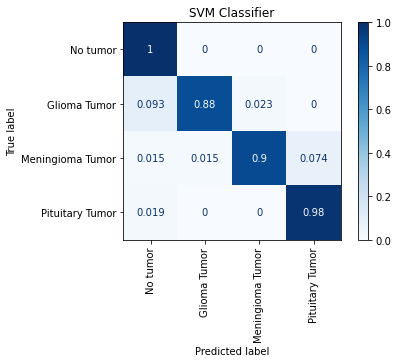

In [78]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.

    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
        {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
         "pca__n_components": [0.96, 0.97, 0.98, 0.99]},
        {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3],
         "pca__n_components": [0.96, 0.97, 0.98, 0.99]}
    ]
    
#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()
    # Create SVC object
    svc = svm.SVC(probability=True)

    pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_svc,
                              parameters,
                              factor=2,
                              scoring='accuracy',
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor'],
        xticks_rotation = 'vertical'
    )
    ax.set_title('SVM Classifier')

    return Y_pred, results

# classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_SVM, target_names=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_SVM)

## 4.3 KNN Classifier
Train and validate a KNN classifier. Halving GridSearchCV module from scikit-learn is used for cross-validating to find the best parameters for the classifier. Parameters tested are the number of features left after PCA and the number of neighbours to use.

The best parameters for the model was then used to predict the labels of the test set. The resulting classification report and confusion matrix is shown to describe the model's performance.

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 53
max_resources_: 3454
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 116
n_resources: 53
Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.400) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.300) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.200) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.400) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train

[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.738, test=0.700) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.690, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.714, test=0.600) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.619, test=0.400) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.643, test=0.200) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.714, test=0.700) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.714, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.667, test=0.400) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.619, test=0.400) total time=   0.0s
[

[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.571, test=0.200) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.619, test=0.700) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.500, test=0.400) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.619, test=0.400) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.429, test=0.400) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.571, test=0.300) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.595, test=0.400) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.548, test=0.200) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.548, test=0.400) total time=   0.0s
[

[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.524, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.571, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.476, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.452, test=0.200) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.548, test=0.600) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.548, test=0.500) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.571, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.452, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.452, test=0.200) total time=

[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.571, test=0.200) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.476, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.405, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.500, test=0.200) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.548, test=0.300) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.571, test=0.200) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.476, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.405, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.452, test=0.200) total time=

[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.548, test=0.200) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.524, test=0.100) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.429, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.452, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.429, test=0.100) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.548, test=0.200) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.524, test=0.100) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.429, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.452, test=0.300) total time=

[CV 3/5] END neigh__n_neighbors=23, pca__n_components=0.99;, score=(train=0.476, test=0.200) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=23, pca__n_components=0.99;, score=(train=0.429, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=23, pca__n_components=0.99;, score=(train=0.476, test=0.300) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.405, test=0.100) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.452, test=0.300) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.476, test=0.200) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.381, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.381, test=0.100) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.429, test=0.200) total time=

[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.98;, score=(train=0.476, test=0.200) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.98;, score=(train=0.429, test=0.100) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.98;, score=(train=0.381, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.98;, score=(train=0.429, test=0.100) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.429, test=0.200) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.476, test=0.200) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.429, test=0.100) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.381, test=0.300) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.452, test=0.100) total time=

[CV 2/5] END neigh__n_neighbors=15, pca__n_components=0.98;, score=(train=0.548, test=0.476) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=15, pca__n_components=0.98;, score=(train=0.464, test=0.476) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=15, pca__n_components=0.98;, score=(train=0.560, test=0.381) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=15, pca__n_components=0.98;, score=(train=0.571, test=0.524) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=10, pca__n_components=0.97;, score=(train=0.607, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=10, pca__n_components=0.97;, score=(train=0.631, test=0.476) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=10, pca__n_components=0.97;, score=(train=0.536, test=0.571) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=10, pca__n_components=0.97;, score=(train=0.607, test=0.667) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=10, pca__n_components=0.97;, score=(train=0.548, test=0.524) total time=

[CV 1/5] END neigh__n_neighbors=14, pca__n_components=0.98;, score=(train=0.500, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=14, pca__n_components=0.98;, score=(train=0.548, test=0.429) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=14, pca__n_components=0.98;, score=(train=0.500, test=0.476) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=14, pca__n_components=0.98;, score=(train=0.548, test=0.619) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=14, pca__n_components=0.98;, score=(train=0.571, test=0.524) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.500, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.571, test=0.524) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.488, test=0.524) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.560, test=0.667) total time=

[CV 4/5] END neigh__n_neighbors=3, pca__n_components=0.98;, score=(train=0.679, test=0.571) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=3, pca__n_components=0.98;, score=(train=0.679, test=0.571) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.655, test=0.381) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.714, test=0.476) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.679, test=0.333) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.631, test=0.667) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=5, pca__n_components=0.97;, score=(train=0.667, test=0.571) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.99;, score=(train=0.631, test=0.333) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.99;, score=(train=0.679, test=0.429) total time=   0.0s
[

[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.679, test=0.476) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.643, test=0.524) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.631, test=0.524) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.429) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.476) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.381) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.524) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.571) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=2, pca__n_components=0.99;, score=(train=0.810, test=0.429) total time=   0.0s
[

[CV 3/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.544, test=0.595) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.521, test=0.643) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.562, test=0.548) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.728, test=0.524) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.793, test=0.571) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.769, test=0.595) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.757, test=0.643) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.769, test=0.690) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.639, test=0.548) total time=   0.0

[CV 2/5] END neigh__n_neighbors=7, pca__n_components=0.98;, score=(train=0.657, test=0.595) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=7, pca__n_components=0.98;, score=(train=0.604, test=0.595) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=7, pca__n_components=0.98;, score=(train=0.657, test=0.643) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=7, pca__n_components=0.98;, score=(train=0.645, test=0.524) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.627, test=0.452) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.645, test=0.643) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.621, test=0.548) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.627, test=0.643) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.633, test=0.595) total time=   0.0s
[

[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.637, test=0.702) total time=   0.1s
[CV 1/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.622, test=0.548) total time=   0.1s
[CV 2/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.655, test=0.536) total time=   0.1s
[CV 3/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.637, test=0.560) total time=   0.1s
[CV 4/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.611, test=0.679) total time=   0.1s
[CV 5/5] END neigh__n_neighbors=11, pca__n_components=0.98;, score=(train=0.649, test=0.714) total time=   0.1s
[CV 1/5] END neigh__n_neighbors=9, pca__n_components=0.98;, score=(train=0.643, test=0.512) total time=   0.1s
[CV 2/5] END neigh__n_neighbors=9, pca__n_components=0.98;, score=(train=0.667, test=0.536) total time=   0.1s
[CV 3/5] END neigh__n_neighbors=9, pca__n_components=0.98;, score=(train=0.661, test=0.595) total time=   

[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.776, test=0.652) total time=   2.6s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.771, test=0.667) total time=   3.2s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.780, test=0.714) total time=   2.7s
[CV 5/5] END neigh__n_neighbors=6, pca__n_components=0.96;, score=(train=0.782, test=0.710) total time=   3.2s
[CV 1/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.827, test=0.711) total time=   2.8s
[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.827, test=0.714) total time=   2.8s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.833, test=0.690) total time=   2.8s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.841, test=0.758) total time=   2.7s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.836, test=0.728) total time=   2.8s
[

,params,mean_train_score,mean_test_score,rank_test_score
230,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.97}",0.955919,0.841841,1
231,"{'neigh__n_neighbors': 3, 'pca__n_components': 0.96}",0.935427,0.823250,2
228,"{'neigh__n_neighbors': 3, 'pca__n_components': 0.96}",0.880991,0.748521,3
229,"{'neigh__n_neighbors': 2, 'pca__n_components': 0.97}",0.909011,0.744391,4
227,"{'neigh__n_neighbors': 4, 'pca__n_components': 0.96}",0.832915,0.720193,5
...,...,...,...,...
101,"{'neigh__n_neighbors': 26, 'pca__n_components': 0.97}",0.414286,0.160000,227
102,"{'neigh__n_neighbors': 26, 'pca__n_components': 0.98}",0.404762,0.160000,227
103,"{'neigh__n_neighbors': 26, 'pca__n_components': 0.99}",0.409524,0.160000,227
108,"{'neigh__n_neighbors': 28, 'pca__n_components': 0.96}",0.433333,0.160000,227


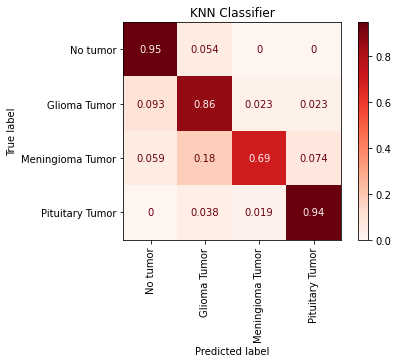

In [79]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;

    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'neigh__n_neighbors': range(1, 30, 1),
                  "pca__n_components": [0.96, 0.97, 0.98, 0.99]}

#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()

    # Create KNN object
    neigh = KNeighborsClassifier(algorithm='auto')

    pca_neigh = Pipeline(steps=[('pca', pca), ('neigh', neigh)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_neigh,
                              parameters,
                              factor=2,
                              scoring='accuracy',
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)

    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Reds,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor'],
        xticks_rotation = 'vertical'
    )
    ax.set_title('KNN Classifier')

    return Y_pred, results


Y_pred_KNN, results_KNN = KNNClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_KNN, target_names=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_KNN)